# OSIRIS-REx: particle size frequency distribution for OREX-800107-0 using size characteristics from Dragonfly
OREX-800107-0 is a 6.4-gram aggregate sample that contains approximately 1.5 million grains. The parent sample was OREX-800013-0.
This code analyzes the particle size frequency distribution (PSFD) using the outputs from the image processing software, Dragonfly. Dragonfly trains a CNN using user annotations to process the XCT data and identify individual particles as isolated islands. The maximum Feret diameter is determined within the software and is loaded into this code and used to plot a PSFD.

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
#import skimage                            # used for image processing
#from scipy import ndimage                 # used to label all the grains
#import os                                 # used to interact with operating systems
#from scipy.spatial.distance import pdist  # pdist = pairwise distances
#from scipy.ndimage import find_objects
from tabulate import tabulate
from scipy.optimize import curve_fit      # used for power law plotting
import pandas as pd

Import the csv file from Dragonfly with the maximum Feret diameter:
-------------------------------------------------------------------

In [3]:
# read the CSV file
DragonflyData = pd.read_csv('orex-800107-0_segmented_stats.csv', delimiter=';', encoding='utf-8')

#print(DragonflyData.head())
#print(DragonflyData.columns.tolist())

FeretMin = DragonflyData['Min Feret Diameter (mm)']
FeretMax = DragonflyData['Max Feret Diameter (mm)']

Define the power-law function:
------------------------------

In [5]:
def PowerLaw(x, a, b):
    '''
        This function computes the power law of a given data set
        inputs:
            x: np.array
                the data (longest axes of particles)
            a: float
                the y-intercept of the power-law fit
            b: float
                the slope of the power-law fit
        outputs: 
            PL: float
                the power law
    '''
    
    PL = a * x ** b

    return PL

Determine error:
---------------

In [7]:
# will probably add to plotting code using the bootstrap method

Plot the PSFD:
--------------

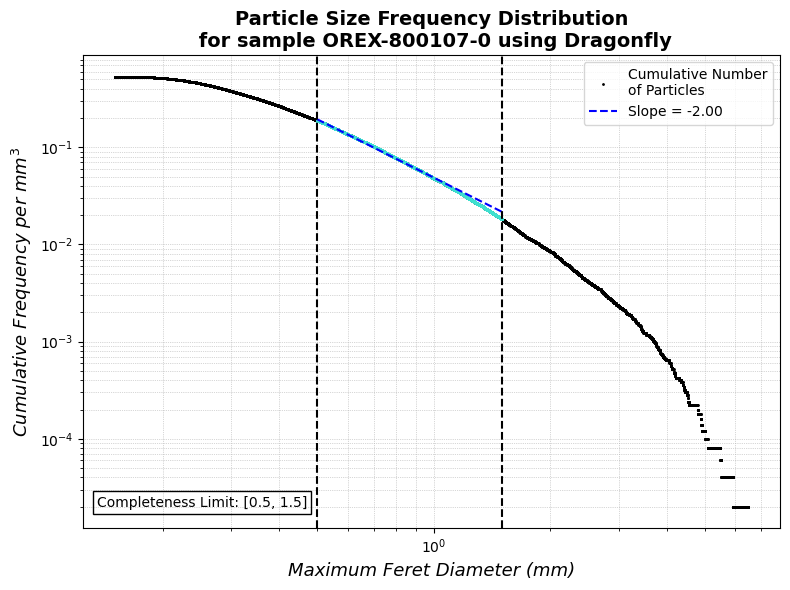

<Figure size 640x480 with 0 Axes>

In [44]:
# NO ERROR CALCULATION

# hard-code total analyzed volume of the sample
# used to normalize the counts
SampleVolume = 5e4   # in mm^3

# define the x-range for fitting the linear slope accurately
xmin_fit = 0.5
xmax_fit = 1.5

# create log-spaced bins for histogram plotting
bins = np.logspace(np.log10(min(FeretMax)), np.log10(max(FeretMax)), 10000)
counts, BinEdges = np.histogram(FeretMax, bins=bins)
# determining the cumulative sum from the smallest to the largest particle
CumulativeCounts = np.cumsum(counts[::-1])[::-1] / SampleVolume  # per mm³
BinCenters = (BinEdges[:-1] + BinEdges[1:]) / 2

# ignore zeros in the counts due to loglog space
mask = CumulativeCounts > 0
x = BinCenters[mask]
y = CumulativeCounts[mask]

# mask the data to be within the selected x-range for accurate fitting
# used to find the slope only based on the portion of the plot that is linear
mask2 = (x >= xmin_fit) & (x <= xmax_fit)
x_fit = x[mask2]
y_fit = y[mask2]

# fit the curve to the dataset
parameters, _ = curve_fit(PowerLaw, x_fit, y_fit, p0=[0.12, -2])
a, b = parameters

# compute y=mx+b line for slope
x_line = np.logspace(np.log10(xmin_fit), np.log10(xmax_fit), 100)
y_line = PowerLaw(x_line, a, b)

# plot the PSFD
plt.figure(figsize=(8,6))
plt.loglog(x, y, 'o', ms=1, label='Cumulative Number\nof Particles', color='black')
# highlight portion of the data that contributes to the slope
plt.loglog(x_fit, y_fit, 'o', ms=1, color='turquoise')
plt.loglog(x_line, y_line, ls='--', ms=10, label=f"Slope = {b:.2f}", color='blue')
# labels and organization
plt.xlabel("Maximum Feret Diameter (mm)", fontsize=13).set_style('italic')
plt.ylabel(f"Cumulative Frequency per $mm^3$", fontsize=13).set_style('italic')
plt.title("Particle Size Frequency Distribution\n for sample OREX-800107-0 using Dragonfly", fontsize=14, weight='bold')
plt.text(0.135, 0.00002, f"Completeness Limit: [{xmin_fit}, {xmax_fit}]", bbox=dict(facecolor='none', edgecolor='black', boxstyle='square')) 
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.axvline(x = xmin_fit, color = 'black', linestyle='--')
plt.axvline(x = xmax_fit, color = 'black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('PSFD_OREX-800107-0_Dragonfly.png')

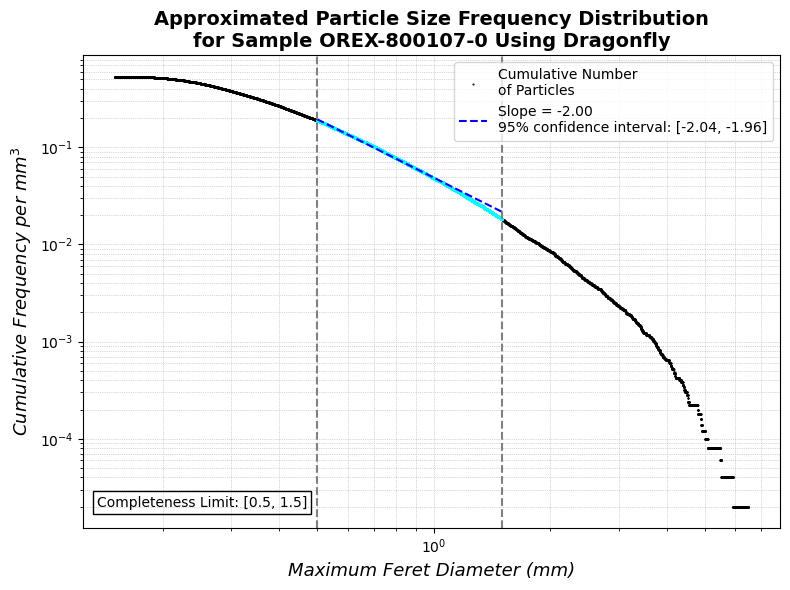

In [46]:
# CALCULATING ERROR WITH BOOTSTRAP METHOD FROM CLAUSSET ET AL.

# hard-code total volume of the sample (approximated)
SampleVolume = 5e4  # in mm^3

# define the x-range for fitting the linear slope accurately
xmin_fit = 0.5
xmax_fit = 1.5

# create log-spaced bins for histogram plotting
bins = np.logspace(np.log10(min(FeretMax)), np.log10(max(FeretMax)), 10000)
BinEdges, _ = np.histogram(FeretMax, bins=bins)
# determine the cumulative sum from the smallest to the largest particle
CumulativeCounts = np.cumsum(BinEdges[::-1])[::-1] / SampleVolume  # per mm³
BinCenters = (bins[:-1] + bins[1:]) / 2

# remove zero counts to avoid log errors
mask = CumulativeCounts > 0
x = BinCenters[mask]
y = CumulativeCounts[mask]

# mask the values for the slope to those previously defined
mask2 = (x >= xmin_fit) & (x <= xmax_fit)
x_fit = x[mask2]
y_fit = y[mask2]

# fit original data to get initial slope
parameteres, _ = curve_fit(PowerLaw, x_fit, y_fit, p0=[0.1, -2.1])
a_fit, b_fit = parameters

# compute the slope line for plotting
x_line = np.logspace(np.log10(xmin_fit), np.log10(xmax_fit), 100)
y_line = PowerLaw(x_line, a_fit, b_fit)

# loop through slope values to find uncertainty
B = 1000  # use at least 5000 for jounral accuracy
BootstrapSlopes = []

for i in range(B):
    # create a randomized data set
    # less biased towards one part of the data
    sample = np.random.choice(FeretMax, size=len(FeretMax), replace=True)
    
    # compute histogram and cumulative counts with randomized data
    bins = np.logspace(np.log10(min(sample)), np.log10(max(sample)), 10000)
    BinEdges, i = np.histogram(sample, bins=bins)
    CumulativeCounts = np.cumsum(BinEdges[::-1])[::-1] / SampleVolume
    BinCenters = (bins[:-1] + bins[1:]) / 2

    # ensure there are no zero counts for log space
    mask3 = CumulativeCounts > 0
    x_bootstrap = BinCenters[mask3]
    y_bootstrap = CumulativeCounts[mask3]

    # ensure the x and y values are within the ranges for best-fit
    mask4 = (x_bootstrap >= xmin_fit) & (x_bootstrap <= xmax_fit)
    x_fit_bootstrap = x_bootstrap[mask4]
    y_fit_bootstrap = y_bootstrap[mask4]

    # try to fit the above power law to the bootstrap data
    try:
        parameters_bootstrap, _ = curve_fit(PowerLaw, x_fit_bootstrap, y_fit_bootstrap, p0=[0.1, -2.1])
        a_bootstrap, b_bootstrap = parameters_bootstrap
        BootstrapSlopes.append(b_bootstrap)
    # if the fit fails, move to the next bootstrap value
    except:
        continue 

# convert list to np array
BootstrapSlopes = np.array(BootstrapSlopes)
mean_slope = np.mean(BootstrapSlopes)
# define confidence intervals
# determine the +/- error for the slope
confidence_lower = np.percentile(BootstrapSlopes, 2.5)  # can change these percentiles
confidence_upper = np.percentile(BootstrapSlopes, 97.5)

# plot the PSFD
plt.figure(figsize=(8, 6))
plt.loglog(x, y, '.', ms=1, label='Cumulative Number\nof Particles', color='black')
# highlight the region of the data that corresponds to the best-fit slope
plt.loglog(x_fit, y_fit, 'o', ms=1, color='cyan')

# plot best fit slope with bootstrap uncertainty
plt.loglog(x_line, y_line, '--', ms=5, 
           label=f"Slope = {b_fit:.2f}\n95% confidence interval: [{confidence_lower:.2f}, {confidence_upper:.2f}]", color='blue')

# labels and organization
plt.xlabel('Maximum Feret Diameter (mm)', fontsize=13).set_style('italic')
plt.ylabel('Cumulative Frequency per mm$^3$', fontsize=13).set_style('italic')
plt.title("Approximated Particle Size Frequency Distribution\nfor Sample OREX-800107-0 Using Dragonfly", fontsize=14, weight='bold')
plt.text(0.135, 0.00002, f"Completeness Limit: [{xmin_fit}, {xmax_fit}]", bbox=dict(facecolor='none', edgecolor='black', boxstyle='square')) 
plt.grid(which='both', linestyle=':', linewidth=0.5)
plt.axvline(x = xmin_fit, color = 'gray', linestyle='--')
plt.axvline(x = xmax_fit, color = 'gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('PSFD_OREX-800107-0_Dragonfly_bootstrap.png')
plt.show()

Determine the number of particles for each size range:
-----------------------------------------------------

In [11]:
# define bins for the particle size range
# 0.01 mm is roughly 1 voxel
# 0.151 mm is the size of the smallest particle in the Dragonfly dataset
bins = [0.01, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0, 5.0, 8.0]  
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

# count the number of particles in each bin
counts, _ = np.histogram(FeretMax, bins=bins)

# create table data
table = list(zip(labels, counts))

print(tabulate(table, headers=["Size Range (mm)", "Number of Particles"], tablefmt="simple"))

Size Range (mm)      Number of Particles
-----------------  ---------------------
0.01-0.15                              0
0.15-0.2                             817
0.2-0.3                             6776
0.3-0.4                             5733
0.4-0.5                             3853
0.5-0.6                             2593
0.6-0.7                             1716
0.7-0.8                             1257
0.8-0.9                              842
0.9-1.0                              628
1.0-1.5                             1492
1.5-2.0                              486
2.0-3.0                              308
3.0-5.0                              111
5.0-8.0                                7
